In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from tqdm.notebook import tqdm
import os
import random

In [14]:
# Define device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Input directory path
INPUT_DIR_PATH = 'm5-forecasting-accuracy/'

In [15]:
# Function to reduce memory usage
def reduce_mem_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

# Function to read data
def read_data():
    sell_prices_df = reduce_mem_usage(pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv'))
    calendar_df = reduce_mem_usage(pd.read_csv(INPUT_DIR_PATH + 'calendar.csv'))
    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df

# Read the data
_, calendar_df, sales_train_validation_df = read_data()

In [16]:
# Prepare date index
dates = calendar_df['date'][:1913]
dates_list = pd.to_datetime(dates).to_list()

# Create item_store_id column
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(
    lambda x: f"{x['item_id']}_{x['store_id']}", axis=1
)

# Create DF_Sales DataFrame
DF_Sales = sales_train_validation_df.loc[:, 'd_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values
DF_Sales.index = pd.to_datetime(dates_list)


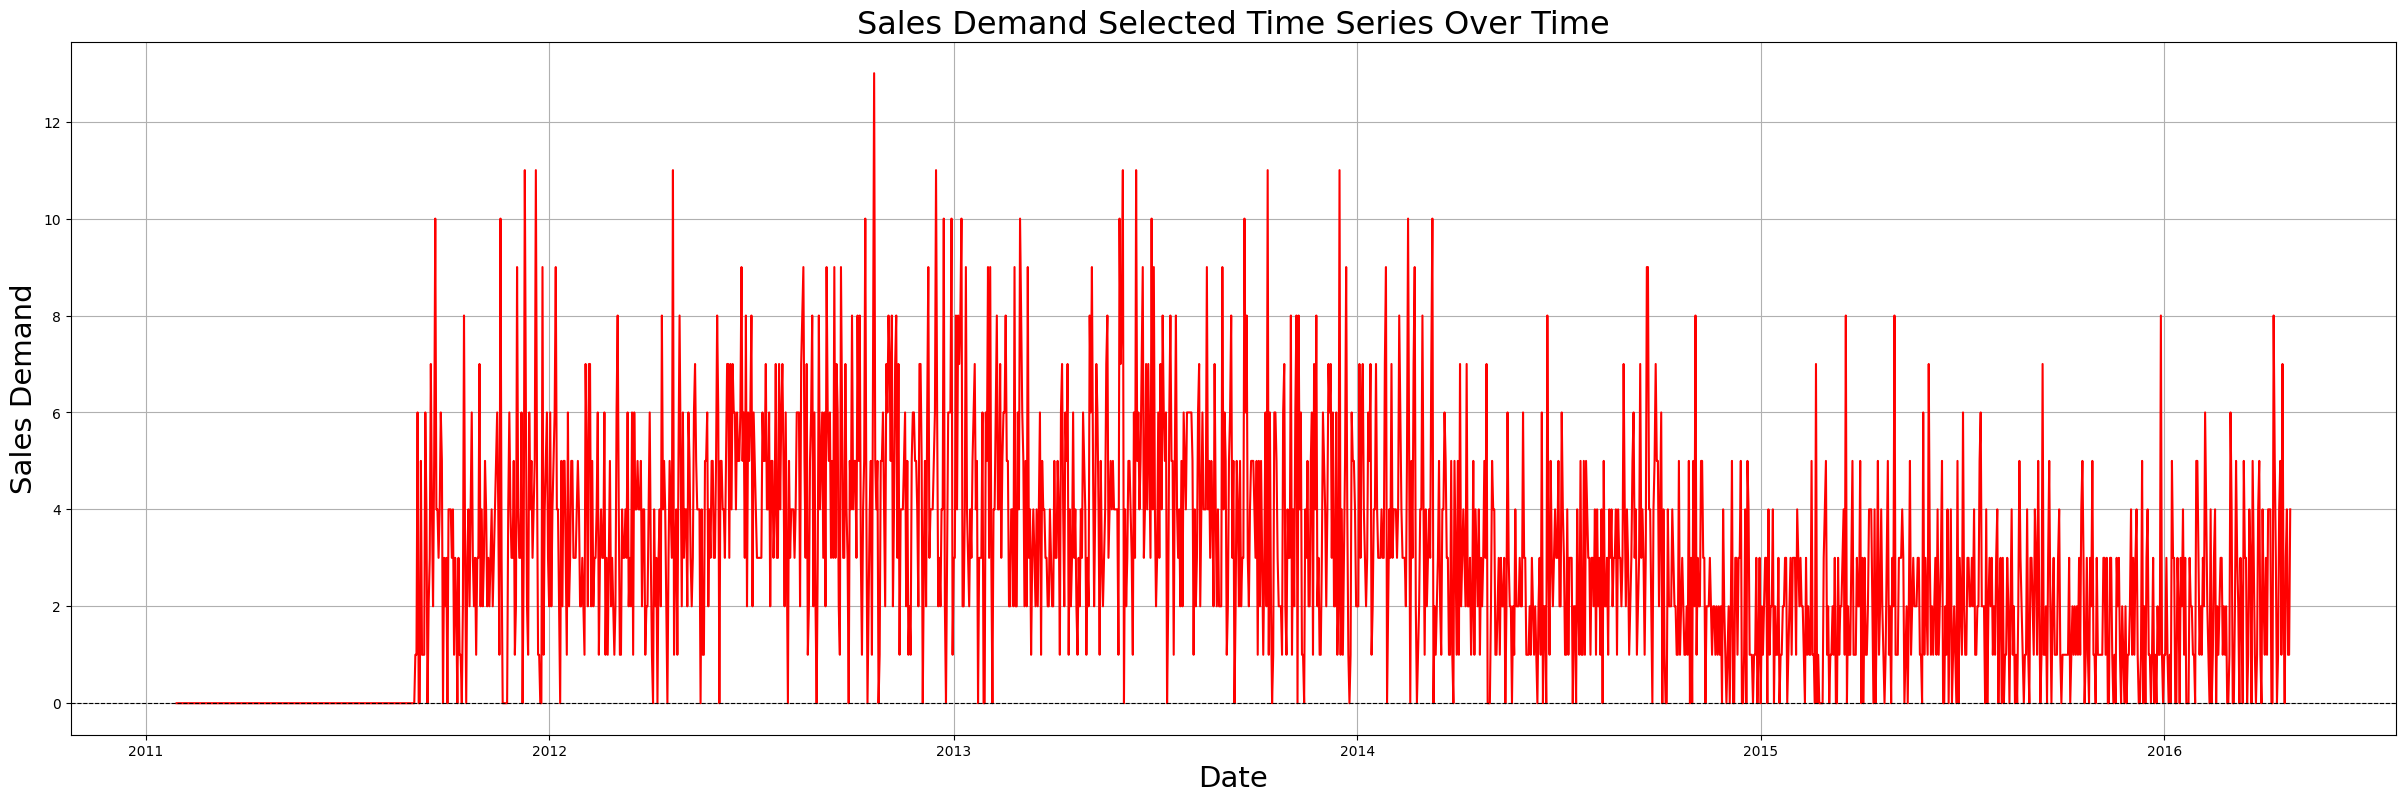

In [17]:

# Select a time series for plotting
index = 6780
y = DF_Sales.iloc[:, index]

# Plotting the time series
plt.figure(figsize=(30, 9))
plt.plot(y, color='red')
plt.axhline(0, color='black', lw=0.8, ls='--')
plt.title('Sales Demand Selected Time Series Over Time', fontsize=23)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.grid()
plt.show()

In [18]:
# Prepare data for LSTM
data = np.array(y).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data)

# Create sliding windows
def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length - 1):
        x.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)

# Split data into training and testing
train_size = int(len(y) * 0.70)
dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))
trainX = Variable(torch.Tensor(x[:train_size]))
trainY = Variable(torch.Tensor(y[:train_size]))
testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))


In [19]:
# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.25)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(num_layers, x.size(0), hidden_size)).to(device)
        c_0 = Variable(torch.zeros(num_layers, x.size(0), hidden_size)).to(device)
        out, (h_out, _) = self.lstm(x, (h_0, c_0))
        return self.fc(h_out[-1])

# Model initialization and training setup
num_epochs = 500
learning_rate = 1e-3
hidden_size = 512
num_layers = 1

lstm = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

C:\Program Files\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [20]:
# Train the model
for epoch in tqdm(range(num_epochs)):
    lstm.train()
    optimizer.zero_grad()
    outputs = lstm(trainX.to(device))
    loss = criterion(outputs, trainY.to(device))
    loss.backward()
    optimizer.step()

# Evaluation
lstm.eval()
train_predict = lstm(dataX.to(device)).cpu().data.numpy()
dataY_plot = dataY.data.numpy()

# Inverse normalization
data_predict = scaler.inverse_transform(train_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

# Create DataFrames for plotting
df_predict = pd.DataFrame(data_predict, index=pd.to_datetime(dates_list[:-seq_length-1]), columns=['Prediction'])
df_labels = pd.DataFrame(dataY_plot, index=pd.to_datetime(dates_list[:-seq_length-1]), columns=['Actual'])

  0%|          | 0/500 [00:00<?, ?it/s]

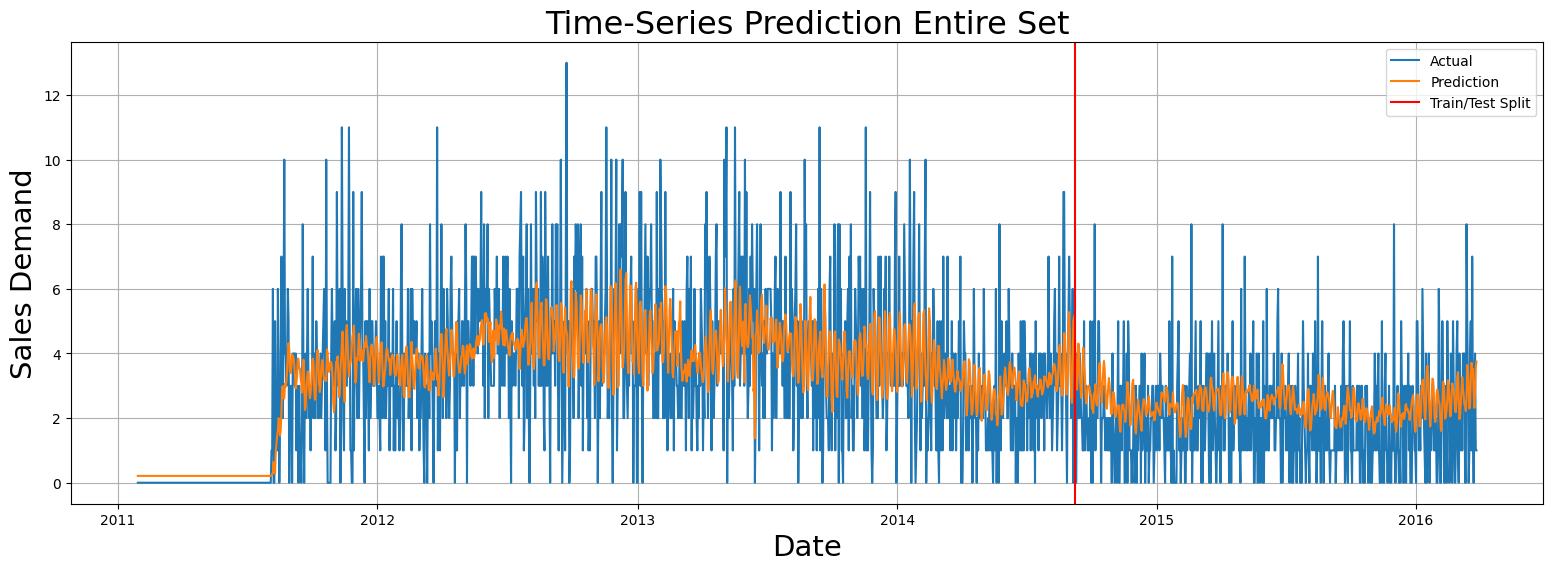

In [21]:
# Plot predictions vs actual values
plt.figure(figsize=(19, 6))
plt.plot(df_labels['Actual'], label='Actual')
plt.plot(df_predict['Prediction'], label='Prediction')
plt.axvline(x=dates_list[train_size], c='r', label='Train/Test Split')
plt.title('Time-Series Prediction Entire Set', fontsize=23)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.legend()
plt.grid()
plt.show()



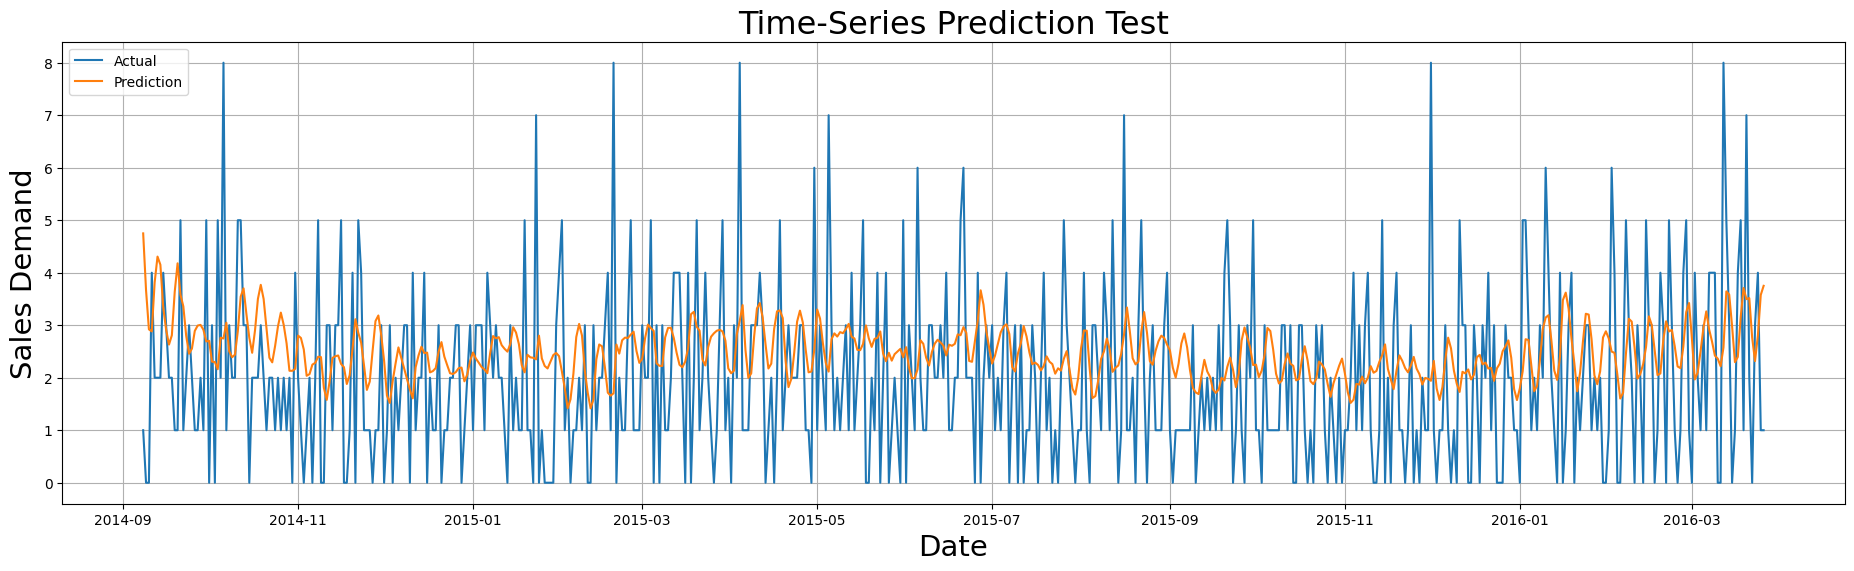

In [22]:

plt.figure(figsize=(23, 6))
plt.plot(df_labels.iloc[-testX.size()[0]:]['Actual'], label='Actual')
plt.plot(df_predict.iloc[-testX.size()[0]:]['Prediction'], label='Prediction')
plt.title('Time-Series Prediction Test', fontsize=23)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.legend()
plt.grid()
plt.show()